# **Course Rating Prediction using Neural Networks**


In our previous Notebook, we have crafted several types of user and item feature vectors. With these explicit features vectors, we can perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value. 

The main advantage of using these explicit features is they are highly interpretable and yield very good performance as well. The main disadvantage is we need to spend quite some effort to build and store them.


Nonetheless, it is possible to predict a rating without building explicit feature vectors beforehand using Neural Networks.

The Non-negative Matrix Factorization decomposes the **user-item interaction matrix** into **user matrix** and **item matrix**, which contain the **latent features** of users and items and we can simply dot-product them to get an estimated rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features. In fact,  neural networks are very good at learning patterns from data and are widely used to extract latent features.  When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.


In the workflow, we first extract two embedding matrices out of the neural network, and aggregate them to be a single interaction feature vector as input data `X`.


## Objectives


After completing this lab you will be able to:


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks
* Build classification models to predict rating modes using the combined embedding vectors


----


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
import math 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [4]:
from keras.layers import Input, Dot, Embedding, Activation, Add
from keras.models import Model
from keras.utils import to_categorical

In [5]:
# also set a random state
rs = 42

### Load and processing rating dataset


In [6]:
rating_df = pd.read_csv('ratings.csv')
print(rating_df.shape)
rating_df.head()

(233306, 3)


,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


The ratings distribute similarly across the 3 categories.

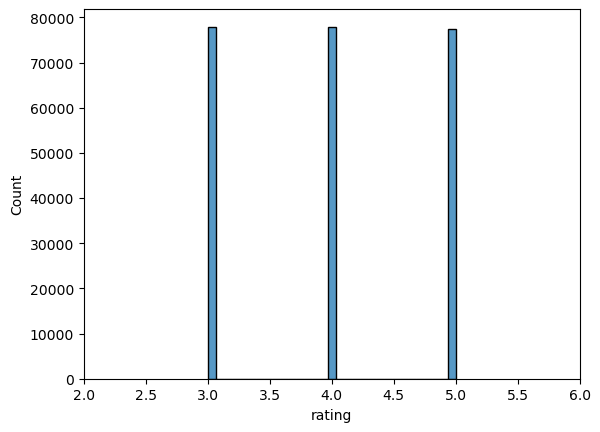

In [7]:
sns.histplot(rating_df['rating'])
ax = plt.gca()
ax.set_xlim([2, 6])
plt.show()

Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [8]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction.

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow


Before training the Neuro Network, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [9]:
def process_dataset(raw_data):
    """
        Preprocesses the raw dataset by encoding user and item IDs to indices.

        Args:
        - raw_data (DataFrame): Raw dataset containing user, item, and rating information.

        Returns:
        - encoded_data (DataFrame): Processed dataset with user and item IDs encoded as indices.
        - user_idx2id_dict (dict): Dictionary mapping user indices to original user IDs.
        - course_idx2id_dict (dict): Dictionary mapping item indices to original item IDs.
    """

    encoded_data = raw_data.copy() # Make a copy of the raw dataset to avoid modifying the original data.

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist() # Get unique user IDs from the dataset.
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)} # Create a dictionary mapping user IDs to indices.
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)} # Create a dictionary mapping user indices back to original user IDs.

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist() # Get unique item (course) IDs from the dataset.
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)} # Create a dictionary mapping item IDs to indices.
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)} # Create a dictionary mapping item indices back to original item IDs.

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict # Return the processed dataset and dictionaries mapping indices to original IDs.

In [10]:
# Process the raw dataset using the process_dataset function
# The function returns three values: encoded_data, user_idx2id_dict, and course_idx2id_dict
# encoded_data: Processed dataset with user and item IDs encoded as indices
# user_idx2id_dict: Dictionary mapping user indices to original user IDs
# course_idx2id_dict: Dictionary mapping item indices to original item IDs
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [11]:
encoded_data.head()

,user,item,rating
0,0,0,5
1,1,1,3
2,2,2,5
3,3,3,5
4,4,4,3


In [12]:
# Define the training variables
x = encoded_data[['user','item']]
y = encoded_data['rating'].values

Then we can split the encoded dataset into training and testing datasets.

In [13]:
# define train, validate, and test sets
x_tr, x_test, y_tr, y_test = train_test_split(x, y, test_size=0.1, random_state = rs)
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.1, random_state = rs)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.

In [14]:
x_train.head()

,user,item
88268,15384,21
138794,12873,99
166242,3421,7
185232,23775,23
131484,9182,99


In [15]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

Then we can choose a small embedding vector size to be **50** and create a Neural Network model to be trained.


In [16]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


In [17]:
embedding_size = 30

# Define input layers for two sets of data
input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

# Define embedding layer for user
embedding_layer_user = Embedding(input_dim=num_users, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-6),
                                 embeddings_initializer="he_normal",
                                 name='embedding_layer_user'
                                 )(input_user)

# Bias is applied per user, hence output_dim is set to 1
bias_layer_user = Embedding(input_dim=num_users, output_dim=1, 
                            embeddings_initializer="zeros",
                            name='bias_layer_user')(input_user)

# Define embedding layer for item
embedding_layer_item = Embedding(input_dim=num_items, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-6),
                                 embeddings_initializer="he_normal",
                                 name='embedding_layer_item'
                                 )(input_item)

# Bias is applied per item, hence output_dim is set to 1
bias_layer_item = Embedding(input_dim=num_items, output_dim=1, 
                            embeddings_initializer="zeros",
                            name='bias_layer_item')(input_item)

# Perform dot product of the two embedded layers
dot_product = Dot(axes=2)([embedding_layer_user, embedding_layer_item])

# Add bias to dot
add_bias = dot_product + bias_layer_user + bias_layer_item

# Add ReLu
add_ReLu = Activation('relu')(add_bias)

# Create the Keras model
model = Model(inputs=[input_user, input_item], outputs=add_ReLu)

opt = keras.optimizers.AdamW(learning_rate=0.003)

# Compile the model
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Display the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_us… │ (None, 1, 30)     │  1,017,030 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_it… │ (None, 1, 30)     │      3,780 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding_layer_… │
│                     │                   │            │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_user     │ (None, 1, 1)      │     33,901 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1)      │          0 │ dot[0][0],        │
│                     │                   │            │ bias_layer_user[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_item     │ (None, 1, 1)      │        126 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1)      │          0 │ add[0][0],        │
│                     │                   │            │ bias_layer_item[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1)      │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,054,837 (4.02 MB)

 Trainable params: 1,054,837 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
run_hist = model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, epochs=10, batch_size=32, shuffle=True, validation_data=([x_val[:,0], x_val[:,1]],y_val)) 

Epoch 1/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 5.5985 - root_mean_squared_error: 2.2664 - val_loss: 0.7645 - val_root_mean_squared_error: 0.8678
Epoch 2/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.7373 - root_mean_squared_error: 0.8523 - val_loss: 0.7196 - val_root_mean_squared_error: 0.8427
Epoch 3/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.7000 - root_mean_squared_error: 0.8317 - val_loss: 0.6946 - val_root_mean_squared_error: 0.8296
Epoch 4/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.6845 - root_mean_squared_error: 0.8238 - val_loss: 0.6831 - val_root_mean_squared_error: 0.8234
Epoch 5/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.6810 - root_mean_squared_error: 0.8224 - val_loss: 0.6805 - val_root_mean_squared_error: 0.8219
Epoch 6/10
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.6776 - root_mean_squared_error: 0.8203 - val_loss: 0.6794 - val_root_mean_squared_error: 0.8214
Epoch 7/10
5906/5906 ━━━━━━━━━━━━━

Text(0.5, 1.0, 'RMSE over iterations')

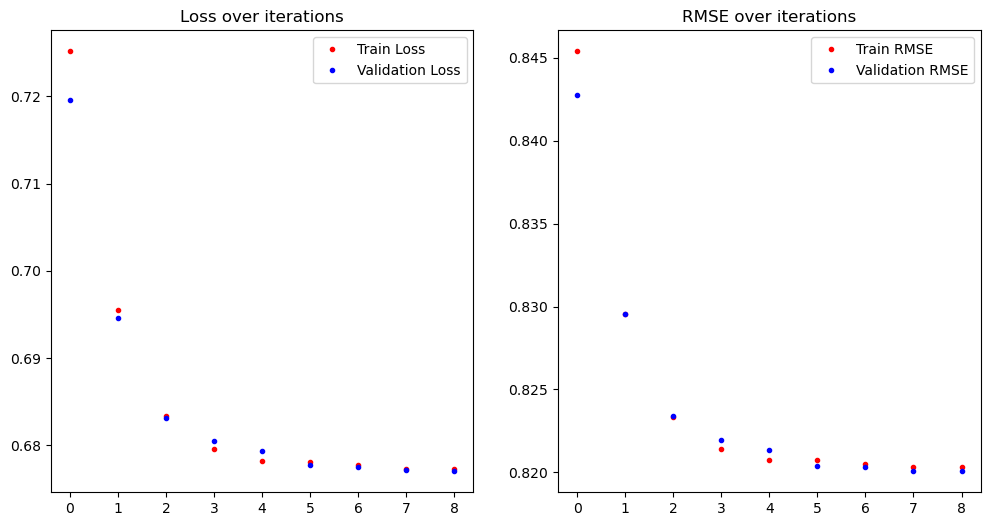

In [19]:
n = len(run_hist.history["loss"])-1

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist.history["loss"][1:]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist.history["val_loss"][1:]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist.history["root_mean_squared_error"][1:]),'r.', label="Train RMSE")
ax.plot(range(n), (run_hist.history["val_root_mean_squared_error"][1:]),'b.', label="Validation RMSE")
ax.legend()
ax.set_title('RMSE over iterations')

In [20]:
# one can save the weights to a file
model.save_weights("recommender_net_weights.weights.h5")

#### Evaluate the trained model


In [21]:
evaluate = model.evaluate(x=[x_test[:,0], x_test[:,1]], y=y_test, batch_size=16)

print('Test loss: ', evaluate[0])
print('Test root_mean_squared_error: ', evaluate[1])



1459/1459 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - loss: 0.6847 - root_mean_squared_error: 0.8247
Test loss:  0.6824983358383179
Test root_mean_squared_error:  0.823388934135437


In [22]:
testPredict = model.predict(x=[x_test[:,0], x_test[:,1]])
print(testPredict.shape)

730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
(23331, 1, 1)


### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained our model and it can predict the ratings with relatively small RMSE.

In the model, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by the neural network and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [23]:
# User features
user_latent_features = model.get_layer('embedding_layer_user').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 30)


In [24]:
item_latent_features = model.get_layer('embedding_layer_item').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 30)


Now, each user of the total 33901 users has been transformed into a 50 x 1 latent feature vector and each item of the total 126 has been transformed into a 50 x 1 latent feature vector.


In [25]:
user_latent_df = pd.DataFrame(data=user_latent_features)#, 
                              #columns=['UFeature0','UFeature1','UFeature2','UFeature3','UFeature4','UFeature5','UFeature6','UFeature7','UFeature8','UFeature9','UFeature10','UFeature11','UFeature12','UFeature13','UFeature14','UFeature15'])
user_latent_df['user'] = user_latent_df.index.map(user_idx2id_dict)
user_latent_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,user
0,-0.106539,0.169725,0.037759,-0.179715,0.004930,-0.025669,-0.081321,-0.060345,-0.005838,-0.079697,...,0.047092,-0.258899,-0.043900,0.003739,0.197900,0.152393,0.024159,0.186125,-0.017375,1889878
1,0.043064,0.014002,0.107306,0.064301,0.106295,-0.053030,0.159673,0.099222,0.039183,-0.015562,...,-0.002050,-0.059056,0.067193,0.075977,-0.055027,0.058501,-0.007581,-0.167742,0.052345,1342067
2,0.039600,0.171552,0.004101,0.035966,-0.149341,-0.000231,-0.165297,-0.110185,0.033201,0.105581,...,0.161102,0.024662,0.069054,-0.066513,0.029164,0.026886,0.148648,0.096873,0.044408,1990814
3,0.120070,-0.198679,0.034901,-0.085777,-0.020262,0.233966,-0.125914,0.086001,0.098813,0.026997,...,-0.150161,0.077233,-0.055136,-0.007019,0.065199,0.159676,-0.101342,-0.154561,0.096996,380098
4,-0.030299,0.059425,-0.089233,-0.037715,0.066093,-0.045554,0.048373,0.000093,0.032430,-0.015075,...,0.013387,0.070763,0.048061,-0.017882,0.118738,-0.011427,-0.124837,-0.010020,0.081052,779563


In [26]:
item_latent_df = pd.DataFrame(data=item_latent_features)#, 
                              #columns=['IFeature0','IFeature1','IFeature2','IFeature3','IFeature4','IFeature5','IFeature6','IFeature7','IFeature8','IFeature9','IFeature10','IFeature11','IFeature12','IFeature13','IFeature14','IFeature15'])
item_latent_df['item'] = item_latent_df.index.map(course_idx2id_dict)
item_latent_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,item
0,-0.016241,-0.103051,0.007395,0.054987,0.055067,0.006007,-0.042313,0.001686,0.073498,-0.035578,...,-0.003626,0.015632,-0.010677,-0.073484,-0.097091,-0.072879,-0.110306,0.079633,-0.084364,CC0101EN
1,-0.027003,-0.086743,0.071170,-0.007644,0.075378,0.189957,0.059592,0.017654,-0.032787,-0.120175,...,0.000152,0.021713,-0.040749,0.232137,-0.021132,-0.026330,0.062515,0.072006,-0.022570,CL0101EN
2,-0.103843,0.217440,0.176883,0.058587,-0.037320,0.041901,0.109647,0.077550,-0.010427,-0.013611,...,-0.057169,0.124602,-0.197989,-0.107890,-0.111450,-0.114045,0.058036,-0.199624,0.259155,ML0120ENv3
3,-0.047253,-0.035368,-0.078138,0.000162,0.033345,-0.037298,0.009164,-0.023665,-0.117988,0.034094,...,0.116564,0.025722,0.001413,0.140056,-0.036409,-0.062878,0.033082,0.042508,-0.130935,BD0211EN
4,-0.050540,0.057302,-0.055438,-0.026285,-0.052446,-0.046933,0.034328,-0.009827,0.057384,-0.068493,...,0.013957,-0.095489,0.006763,-0.055791,0.034223,-0.041170,0.082775,-0.108192,0.064673,DS0101EN


In [27]:
rating_df_2 = rating_df.copy()

df_2 = pd.merge(rating_df_2,user_latent_df, how='left', on='user').fillna(0)
df_3 = pd.merge(df_2, item_latent_df, how='left', on='item').fillna(0)
df_3.head()

,user,item,rating,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y
0,1889878,CC0101EN,5,-0.106539,0.169725,0.037759,-0.179715,0.004930,-0.025669,-0.081321,...,-0.073589,-0.003626,0.015632,-0.010677,-0.073484,-0.097091,-0.072879,-0.110306,0.079633,-0.084364
1,1342067,CL0101EN,3,0.043064,0.014002,0.107306,0.064301,0.106295,-0.053030,0.159673,...,-0.053792,0.000152,0.021713,-0.040749,0.232137,-0.021132,-0.026330,0.062515,0.072006,-0.022570
2,1990814,ML0120ENv3,5,0.039600,0.171552,0.004101,0.035966,-0.149341,-0.000231,-0.165297,...,-0.047942,-0.057169,0.124602,-0.197989,-0.107890,-0.111450,-0.114045,0.058036,-0.199624,0.259155
3,380098,BD0211EN,5,0.120070,-0.198679,0.034901,-0.085777,-0.020262,0.233966,-0.125914,...,-0.027686,0.116564,0.025722,0.001413,0.140056,-0.036409,-0.062878,0.033082,0.042508,-0.130935
4,779563,DS0101EN,3,-0.030299,0.059425,-0.089233,-0.037715,0.066093,-0.045554,0.048373,...,0.005192,0.013957,-0.095489,0.006763,-0.055791,0.034223,-0.041170,0.082775,-0.108192,0.064673


Next, we can combine the user features (the column labels with `_x`) and item features (the column labels with `_y`). In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:

In [28]:
ufeature = df_3.iloc[:,3+embedding_size:].values
ifeature = df_3.iloc[:,3:3+embedding_size].values

In [29]:
summ_UI = ufeature + ifeature
features_df = pd.concat([df_3[['user','item','rating']], pd.DataFrame(data=summ_UI)],axis=1)
features_df.head()

,user,item,rating,0,1,2,3,4,5,6,...,20,21,22,23,24,25,26,27,28,29
0,1889878,CC0101EN,5,-0.122779,0.066674,0.045154,-0.124728,0.059997,-0.019662,-0.123634,...,-0.116998,0.043467,-0.243266,-0.054577,-0.069745,0.100810,0.079515,-0.086147,0.265758,-0.101739
1,1342067,CL0101EN,3,0.016062,-0.072741,0.178477,0.056657,0.181673,0.136927,0.219265,...,-0.206626,-0.001898,-0.037344,0.026444,0.308114,-0.076159,0.032171,0.054934,-0.095736,0.029776
2,1990814,ML0120ENv3,5,-0.064243,0.388992,0.180984,0.094553,-0.186661,0.041670,-0.055650,...,-0.248554,0.103933,0.149265,-0.128934,-0.174402,-0.082286,-0.087159,0.206683,-0.102751,0.303564
3,380098,BD0211EN,5,0.072817,-0.234047,-0.043238,-0.085615,0.013083,0.196668,-0.116750,...,0.293288,-0.033597,0.102955,-0.053723,0.133037,0.028790,0.096798,-0.068260,-0.112052,-0.033939
4,779563,DS0101EN,3,-0.080839,0.116727,-0.144671,-0.064000,0.013647,-0.092487,0.082701,...,0.035115,0.027344,-0.024726,0.054824,-0.073673,0.152961,-0.052597,-0.042063,-0.118212,0.145725


We define new training and test sets for linear regression.

In [30]:
X_features = features_df.iloc[:,3:]
y_features = features_df.iloc[:,2]

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state = rs)

## Train Linear Regrassion (Ridge) on predicted rating

In [32]:
# Define a Linear regression model with above arguments
linear_regressor = Ridge()
linear_regressor.fit(x_train, y_train)


Ridge()

In [33]:
regressor_predict = linear_regressor.predict(x_test)
regressor_score = math.sqrt( mean_squared_error(y_test, regressor_predict) )

print(f"Test root_mean_squared_error for linear regression is {round(regressor_score, 2)}")

Test root_mean_squared_error for linear regression is 0.82


The `RMSE` for linear regression is very similar to **KNN** and **NMF** models.

----